In [ ]:
!pip install fcapy==0.1.4.1
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
#!pip install bitarray
#!pip install bitsets

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report

from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

import neural_lib as nl

# Pipeline

In [ ]:
df = pd.read_csv('/content/diabetes.csv')
print(df.shape)
df.sample()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
17,7,107,74,0,0,29.6,0.254,31,1


# Step 0. Binarize the data

In [ ]:
df_bin = pd.DataFrame()
#1
df_bin['Pregnancies<6'] = df['Pregnancies'] < 6
df_bin['Pregnancies>=6'] = df['Pregnancies'] >= 6
#2
df_bin['Glucose>=150'] = df['Glucose'] >= 150
df_bin['Glucose<150'] = df['Glucose'] < 150
#3
df_bin['BMI>40'] = df['BMI'] > 40
df_bin['BMI<40'] = df['BMI'] < 40
#7
df_bin['DiabetesPedigreeFunction>=1'] = df['DiabetesPedigreeFunction'] >= 1
df_bin['DiabetesPedigreeFunction<1'] = df['DiabetesPedigreeFunction'] < 1
#8
df_bin['Age>=60'] = df['Age'] >= 60
df_bin['Age>=40<60'] = (df['Age'] < 60) & (df['Age'] >= 40)
df_bin['Age<40'] = df['Age'] < 40

df_bin['Outcome'] = df['Outcome'] == 1

In [ ]:
df_bin['sample_id'] = np.arange(0, df_bin.shape[0], 1).astype(str)
df_bin['id'] = df_bin['sample_id'].apply(lambda x: 'h' + x)
df_bin.drop(columns=['sample_id'], inplace=True)
df_bin=df_bin.set_index('id')
df_bin.sample()

,Pregnancies<6,Pregnancies>=6,Glucose>=150,Glucose<150,BMI>40,BMI<40,DiabetesPedigreeFunction>=1,DiabetesPedigreeFunction<1,Age>=60,Age>=40<60,Age<40,Outcome
id,,,,,,,,,,,,
h405,True,False,False,True,True,False,False,True,False,False,True,False


Split the data to train and test

In [ ]:
y_feat = 'Outcome'
df_train, df_test = train_test_split(df_bin, train_size=0.7, random_state=0)

X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]
X_train.sample()

,Pregnancies<6,Pregnancies>=6,Glucose>=150,Glucose<150,BMI>40,BMI<40,DiabetesPedigreeFunction>=1,DiabetesPedigreeFunction<1,Age>=60,Age>=40<60,Age<40
id,,,,,,,,,,,
h321,True,False,False,True,False,True,False,True,False,False,True


## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [ ]:
%%time 
K_train = FormalContext.from_pandas(X_train)
K_train

CPU times: user 2.01 ms, sys: 0 ns, total: 2.01 ms
Wall time: 2.02 ms


FormalContext (537 objects, 11 attributes, 2684 connections)
    |Pregnancies<6|Pregnancies>=6|Glucose>=150|Glucose<150|BMI>40|...|DiabetesPedigreeFunction>=1|DiabetesPedigreeFunction<1|Age>=60|Age>=40<60|Age<40|
h580|            X|              |           X|           |     X|...|                           |                         X|       |          |     X|
h418|            X|              |            |          X|      |...|                           |                         X|       |          |     X|
h764|            X|              |            |          X|      |...|                           |                         X|       |          |     X|
h363|            X|              |            |          X|      |...|                           |                         X|      X|          |      |
h757|            X|              |            |          X|      |...|                           |                         X|       |         X|      |
h636|            X|        

In [ ]:
%%time 

L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

CPU times: user 1.95 s, sys: 7.83 ms, total: 1.96 s
Wall time: 1.98 s


322

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [ ]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)
    c.measures['recall_score'] = recall_score(y_train, y_preds)

Select indices of the best concepts from the lattice

In [ ]:
n_concepts = 40
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:n_concepts])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [ ]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [ ]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

Move the nodes in visualization to make it look pretty

In [ ]:
'''
vis.init_mover_per_poset(cn.poset)
mvr = vis.mover
for a, b in [(11, 15), (2, 3), (2,8), (2, 4), (4,5), (24, 26), (22, 26), (23, 25), (22, 24), (6, 7), ]:
    mvr.swap_nodes(a, b)
    
for nodes, vert in [
    ([19, 18], 0), ([23, 22], 5), ([14, 21,20], 1), ([13, 24, 25], 6), ([26], 7), ([9, 15], 8)
]:
    for a in nodes:
        mvr.place_node(a, mvr.posx[vert])
'''

In [ ]:
set(df_test.columns)

{'Age<40',
 'Age>=40<60',
 'Age>=60',
 'BMI<40',
 'BMI>40',
 'DiabetesPedigreeFunction<1',
 'DiabetesPedigreeFunction>=1',
 'Glucose<150',
 'Glucose>=150',
 'Outcome',
 'Pregnancies<6',
 'Pregnancies>=6'}

In [ ]:
descr = {'Glucose>=150'}

traced = cn.trace_description(descr, include_targets=False)

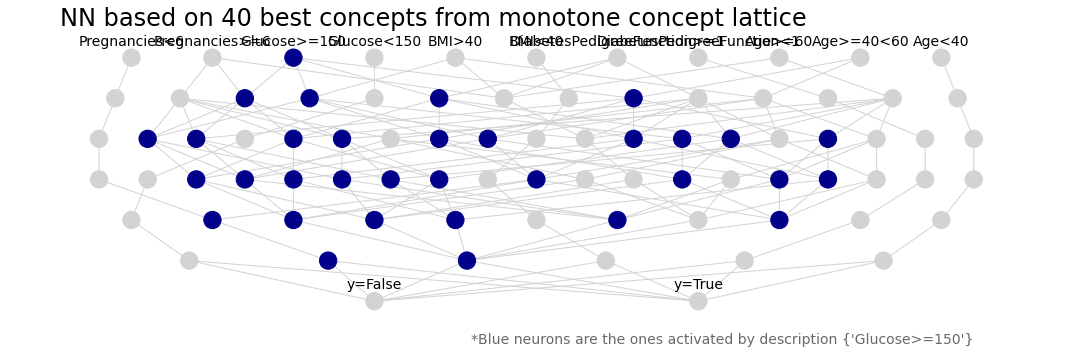

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on '+str(n_concepts)+' best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('nn_another_baseline.png')
plt.show()

Now fit the network

In [ ]:
cn.fit(X_train, y_train,  n_epochs = 10000)

To obtain the prediction

In [ ]:
y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

Class prediction [1 0 0 1 0 0 1 1 0 1]
Class prediction with probabilities [[2.4268577e-02 9.7573143e-01]
 [9.9991822e-01 8.1751932e-05]
 [9.9991822e-01 8.1751932e-05]
 [2.4268577e-02 9.7573143e-01]
 [9.9991822e-01 8.1751932e-05]
 [9.9991822e-01 8.1751932e-05]
 [2.4268577e-02 9.7573143e-01]
 [2.4268577e-02 9.7573143e-01]
 [9.9982041e-01 1.7961941e-04]
 [4.3915674e-01 5.6084329e-01]]
True class [ True False False  True False False  True  True False False]


Check our metrics

In [ ]:
print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))

Recall score: 0.527027027027027
F1     score: 0.5416666666666666


Let's also check accuracy and classification report

In [ ]:
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Accuracy score: 0.7142857142857143


In [ ]:
print(classification_report(y_test.values.astype('int'), y_pred))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       157
           1       0.56      0.53      0.54        74

    accuracy                           0.71       231
   macro avg       0.67      0.66      0.67       231
weighted avg       0.71      0.71      0.71       231



Let's at least test it on train data

In [ ]:
y_pred = cn.predict(X_train).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_train).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_train.values[:10])

Class prediction [1 0 0 0 0 0 1 0 1 1]
Class prediction with probabilities [[2.4268577e-02 9.7573143e-01]
 [9.9991822e-01 8.1751932e-05]
 [9.9991822e-01 8.1751932e-05]
 [9.9999642e-01 3.6085057e-06]
 [5.7380766e-01 4.2619231e-01]
 [5.7380766e-01 4.2619231e-01]
 [2.4268577e-02 9.7573143e-01]
 [5.7380766e-01 4.2619231e-01]
 [2.4268577e-02 9.7573143e-01]
 [4.3915674e-01 5.6084329e-01]]
True class [ True False False  True  True False  True False  True False]


In [ ]:
print('Recall score:', recall_score(y_train.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_train.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_train.values.astype('int'), y_pred))

Recall score: 0.5927835051546392
F1     score: 0.6301369863013698
Accuracy score: 0.7486033519553073


Let us look at the fitted weights of edges

In [ ]:
edge_weights = cn.edge_weights_from_network()

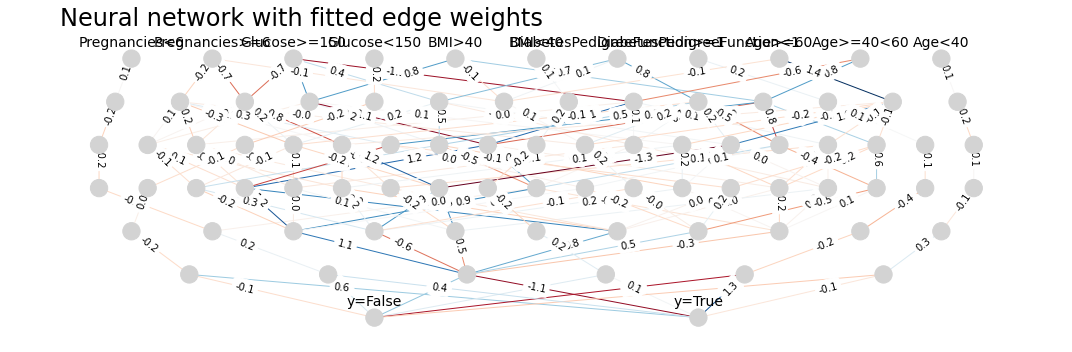

In [ ]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network_another_baseline.png')
plt.show()